In [1]:
import numpy as np
from confectionery import Confectionery
from cluster_half_shelfs_beta import Half_shelf_cluster
from low_pass import LowPass
from matplotlib import pyplot as plt
from matplotlib import cm
import cv2 as cv
from sklearn.mixture import GaussianMixture
from scipy.stats import norm


In [2]:
# load all necessary data
object_trajectory=my_data = np.genfromtxt('/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/object_0_trajectory.csv', delimiter=',')
object_trajectory=object_trajectory[1:,:]
stream_string=[]
koppenrath=Confectionery()
for i in range(object_trajectory.shape[0]):
    frame_number=round(object_trajectory[i,0])
    im_path="Image_Data/Aufnahmen_JPEG_06_07_take_2/Hoang_07_06_2023_Aufnahmen_Rollen_Partikel_Rollen_12_mu_200_002_t"+str(frame_number).zfill(3)+".jpg"
    stream_string.append(im_path)
lp=LowPass(koppenrath)
# cluster
half_shelf_cluster=Half_shelf_cluster(object_trajectory, stream_string, confectionery=koppenrath, lowpass=lp)
half_shelf_cluster.load_derivatives_initial(frame_portion=1.0)


data_derivative_r=half_shelf_cluster.load_derivative_on_radius()


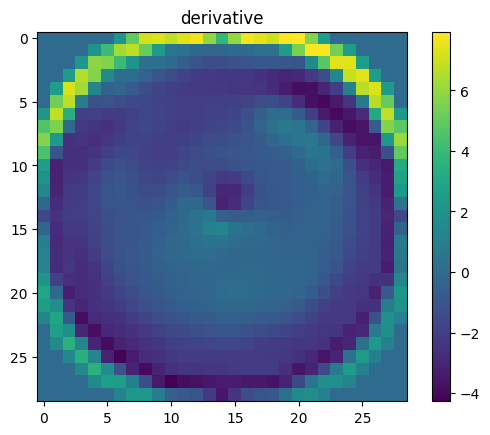

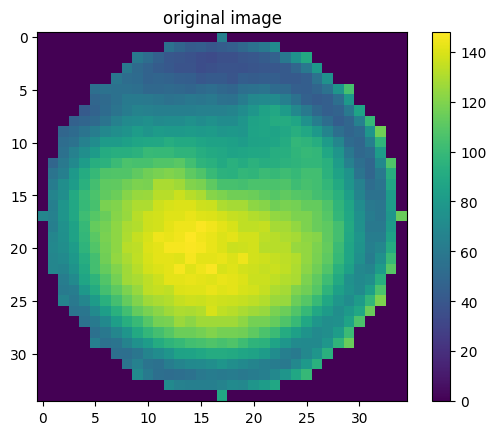

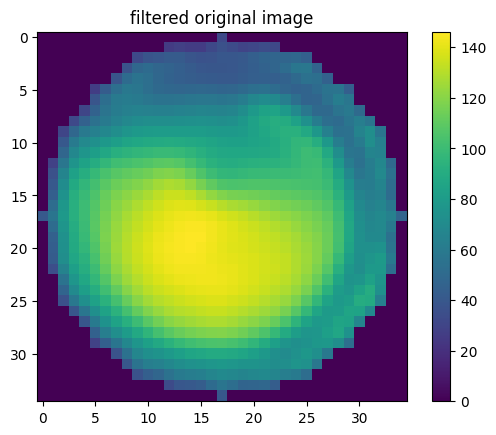

In [3]:
derivatives=half_shelf_cluster.derivatives
frame=30
current_derivative=derivatives[frame]
obj_image_current=cv.imread(stream_string[frame], cv.IMREAD_GRAYSCALE)
object_indeces=np.s_[round(object_trajectory[frame,2]-np.ceil(object_trajectory[frame,3])):round(object_trajectory[frame,2]+np.ceil(object_trajectory[frame,3]))+1,
                    round(object_trajectory[frame,1]-np.ceil(object_trajectory[frame,3])):round(object_trajectory[frame,1]+np.ceil(object_trajectory[frame,3]))+1]
obj_image_current=obj_image_current[object_indeces]
obj_image_current_filtered=lp.current_filter(obj_image_current)
#obj_image_current_filtered=obj_image_current
lp.read_obj_image(obj_image_current)
obj_image_current=lp.cut_cake((obj_image_current_filtered.shape[0]-1)//2)
plt.figure()
plt.title("derivative")
plt.imshow(current_derivative)
plt.colorbar()
plt.figure()
plt.title("original image")
plt.imshow(obj_image_current)
plt.colorbar()
plt.figure()
plt.title("filtered original image")
plt.imshow(obj_image_current_filtered)
plt.colorbar()

In [4]:
M=koppenrath.sell_cake(12,obj_image_current.shape[0],obj_image_current.shape[0])
A=obj_image_current[M==1].astype(np.float32)
B=obj_image_current_filtered[M==1].astype(np.float32)
error=np.mean(np.abs(A-B))
print("mean error filter: " + str(error))

mean error filter: 1.1674306


In [5]:
for j in range(6,(current_derivative.shape[0]+1)//2):
    if j==0:
        index=koppenrath.sell_cake(j,current_derivative.shape[0],current_derivative.shape[0])
    else:
        index=koppenrath.sell_donut(j,current_derivative.shape[0],current_derivative.shape[0])
    pixel_values=current_derivative[index==1]
    print("radius :", str(j))
    print(np.mean(pixel_values))


radius : 6
-0.7288120648302769
radius : 7
-0.8001386856666806
radius : 8
-0.8145654056652806
radius : 9
-0.8501182134393195
radius : 10
-1.2118536752879767
radius : 11
-1.8941194103260441
radius : 12
-2.306402427389534
radius : 13
-2.2703326044455623
radius : 14
-2.112658777146629


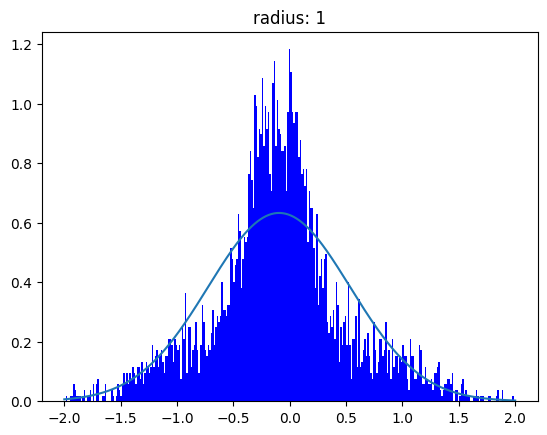

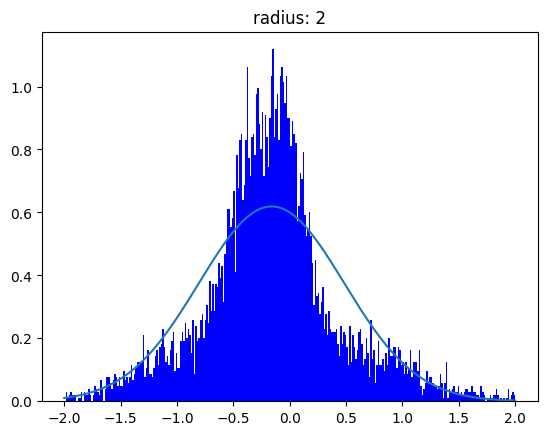

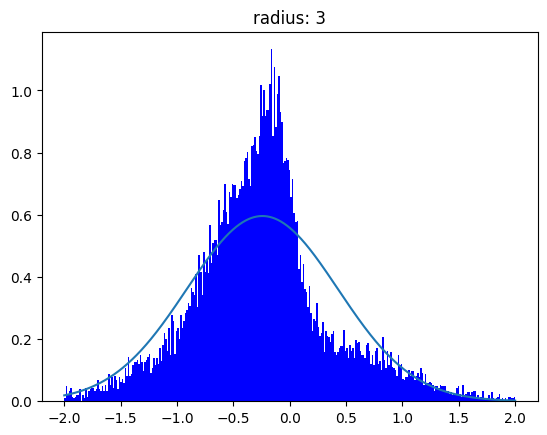

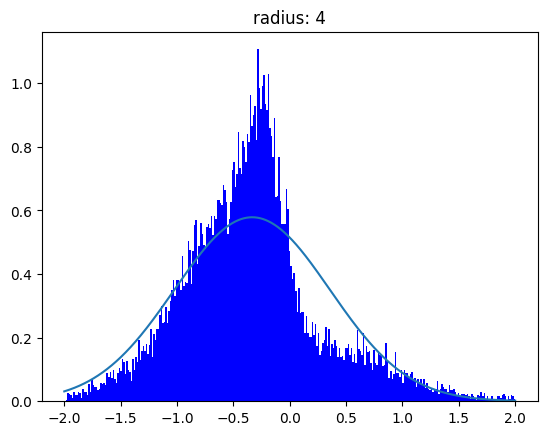

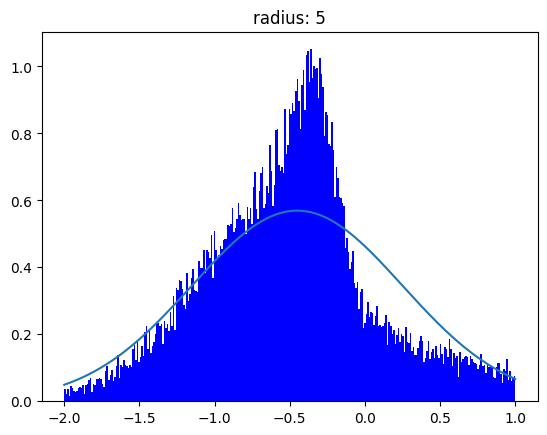

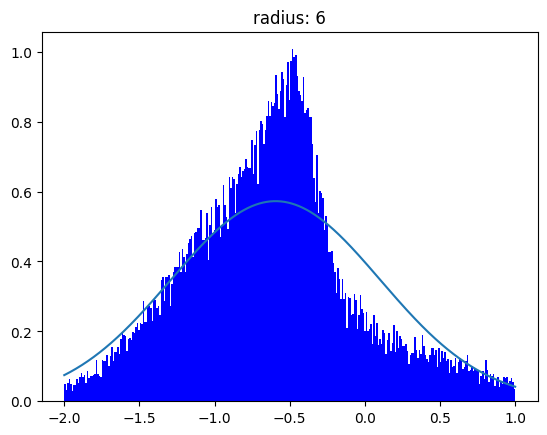

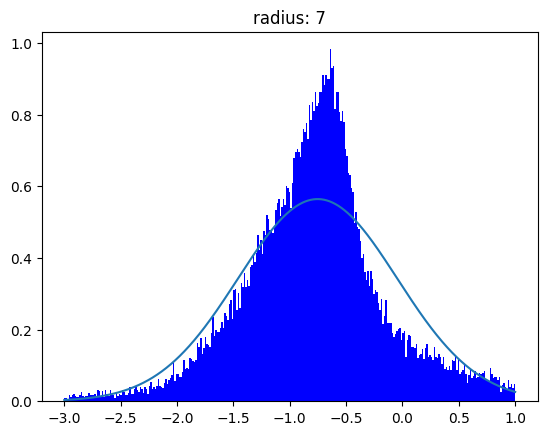

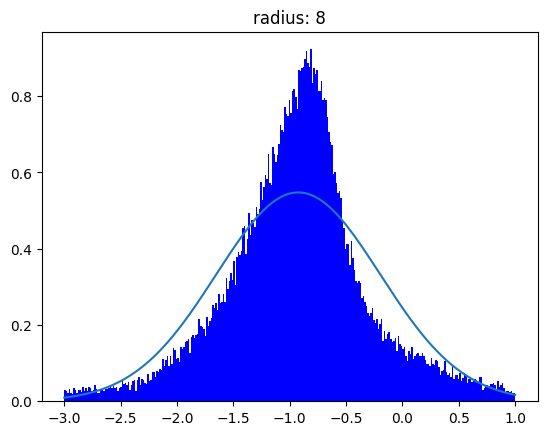

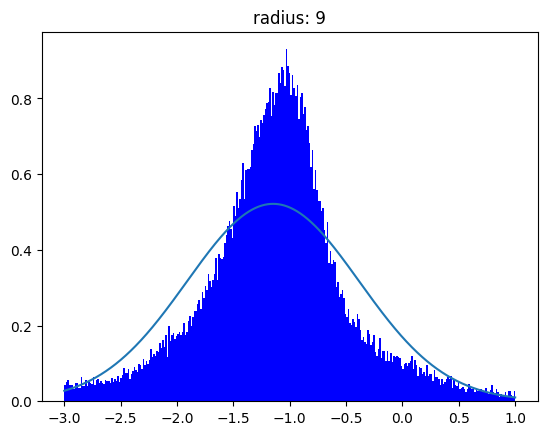

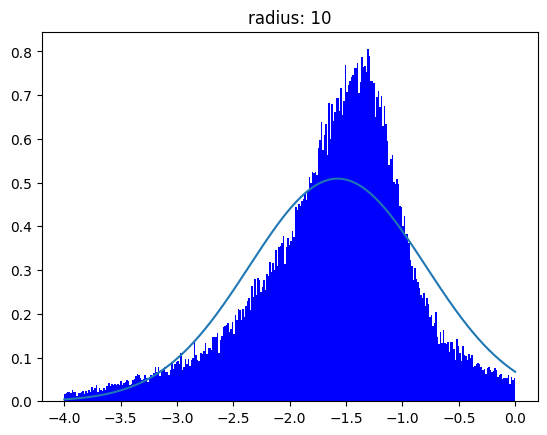

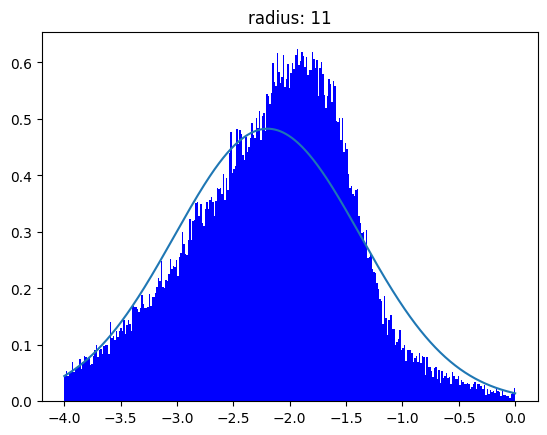

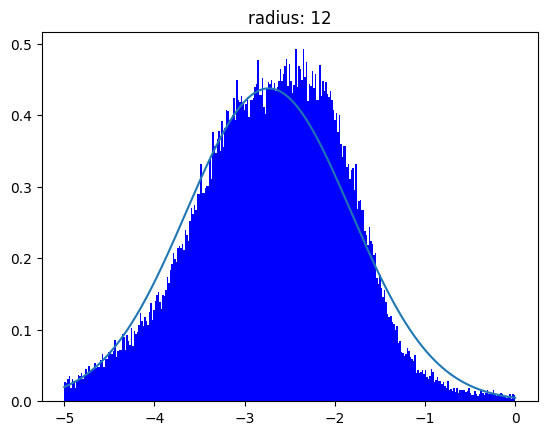

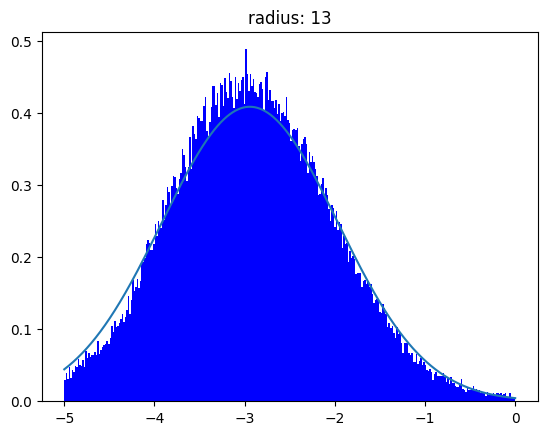

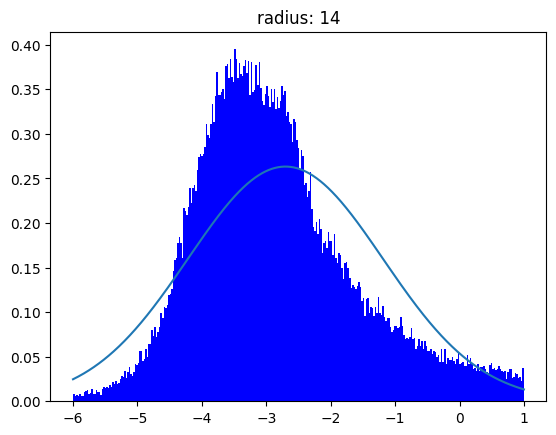

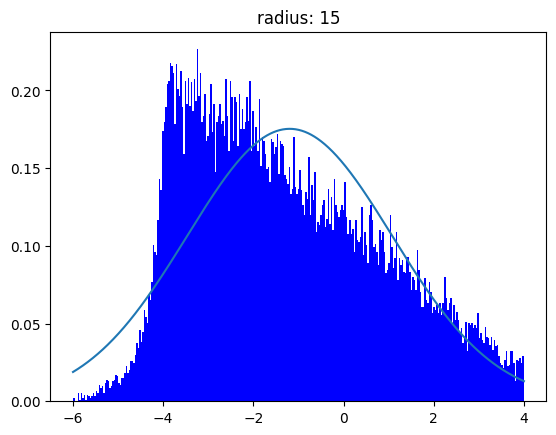

In [6]:
for i in range(1,len(data_derivative_r)):
    ax=plt.figure()
    plt.title("radius: "+str(i))
    data=data_derivative_r[i]
    try:
        Number_bins=300
        gauss=GaussianMixture(n_components=1, random_state=0).fit(data.reshape((-1,1)))
        gauss_mean = gauss.means_.reshape((-1))
        gauss_variance = gauss.covariances_.reshape((-1))
        mean=np.mean(data)
        variance=np.sum((data-mean)**2)/(data.size-1)
        min_edge = round(np.floor(mean-2*np.sqrt(variance)))
        max_edge = round(np.ceil(mean+2*np.sqrt(variance)))
        bins=np.linspace(min_edge, max_edge, Number_bins)
        n, bins, patches = plt.hist(data, bins=bins, color = "blue", density=True)
        # plot gaussian
        x = np.linspace(min_edge,max_edge, 1000)
        plt.plot(x, norm.pdf(x, gauss_mean, np.sqrt(gauss_variance)))
    except:
        print("error")
plt.show()

Print depending on radius ratio of how many points are less than threshold d

In [7]:
d=-1.5
print("Threshold: " +str(d))
for i in range(8,len(data_derivative_r)):
    data=data_derivative_r[i]
    print("radius: " +str(i))
    ratio=np.sum(data<d)/data.size
    print("percentage: " +str(ratio))

Threshold: -1.5
radius: 8
percentage: 0.16335610661268557
radius: 9
percentage: 0.24781304222093695
radius: 10
percentage: 0.5081604251012146
radius: 11
percentage: 0.836808367071525
radius: 12
percentage: 0.9383065536437247
radius: 13
percentage: 0.9351421604711079
radius: 14
percentage: 0.8278990746096009
radius: 15
percentage: 0.5141918344519015


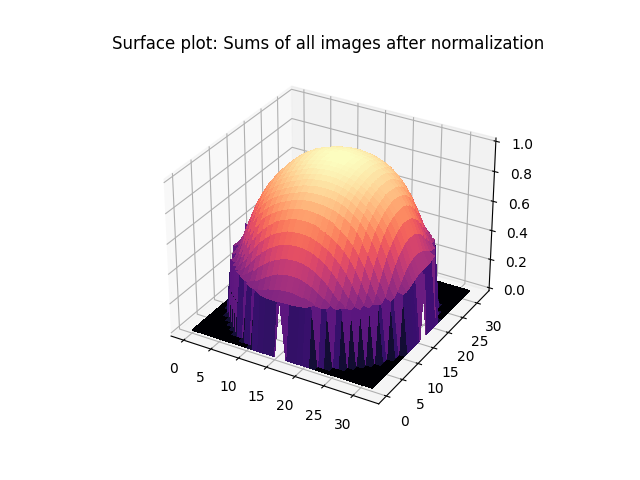

In [8]:
%matplotlib ipympl
tensor=half_shelf_cluster.object_tensor
sum_im=np.sum(tensor,axis=2)
radius=round(np.floor(np.min(object_trajectory[:,-1])))-1
lp=LowPass(koppenrath)
lp.read_obj_image(sum_im)
sum_im=lp.cut_cake(radius=radius)
sum_im_normalized=sum_im/np.max(sum_im)
# Make data.
X = np.arange(sum_im.shape[0])
X, Y = np.meshgrid(X, X)


fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, sum_im_normalized, cmap=cm.magma,linewidth=0,antialiased=False)
ax.set_title('Surface plot: Sums of all images after normalization')
plt.show()


In [9]:
from radial_derivative import RadialDerivative
import numpy.fft as nf
lp=LowPass(koppenrath, delta_radius=0)
sum_im_normalized=np.pad(sum_im_normalized,[(3,3),(3,3)],mode='constant')
lp.read_obj_image(sum_im_normalized)
sum_im_normalized=lp.cut_cake(radius=radius)
filtered_image=lp.butter_worth_lowpass()

radial_der=RadialDerivative(filtered_image,koppenrath)
der=radial_der.calculate_derivative()

der_alt=lp.derivative_filter(sum_im)



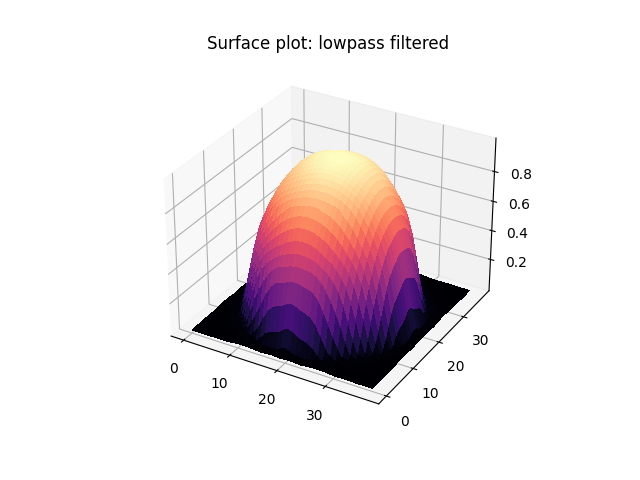

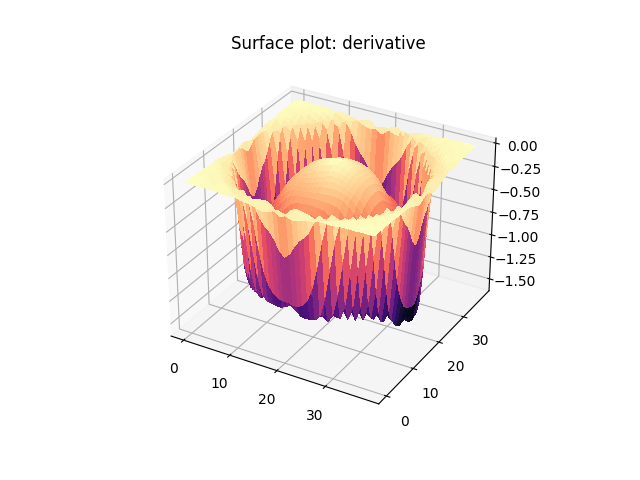

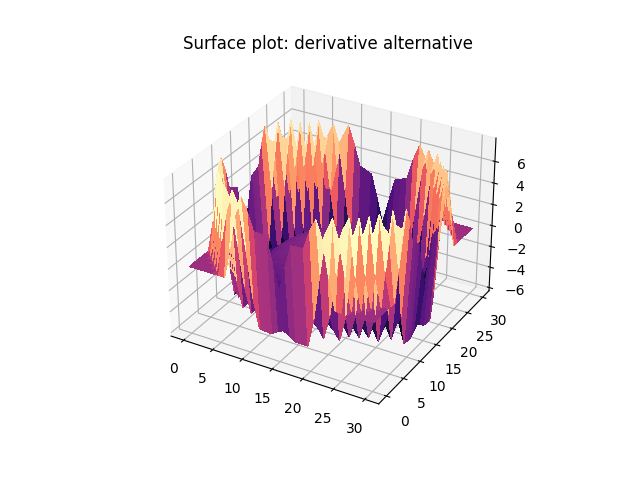

In [10]:
X = np.arange(filtered_image.shape[0])
X, Y = np.meshgrid(X, X)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, filtered_image, cmap=cm.magma,linewidth=0,antialiased=False)
ax.set_title('Surface plot: lowpass filtered')
plt.show()

X = np.arange(der.shape[0])
X, Y = np.meshgrid(X, X)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, der, cmap=cm.magma,linewidth=0,antialiased=False)
ax.set_title('Surface plot: derivative')
plt.show()

X = np.arange(der_alt.shape[0])
X, Y = np.meshgrid(X, X)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, der_alt, cmap=cm.magma,linewidth=0,antialiased=False)
ax.set_title('Surface plot: derivative alternative')
plt.show()

